# Pocking at Ever Larger Language Models
### An introduction for (digital) humanists

## Part 1: Exploring n-gram language models

In this notebook we look more closely at how the build a simple n-gram language model and use this model to generate new sentences.

Main topics discussed in this notebook:
- Language models as **distributions over sequences**
- Generating new texts by **sampling** from this distribution


## Introduction 

In this tutorial we use news coverage on Brexit. You will learn how to generate Brexit prose, yay! The same material is also used in the Programming Historian lesson on [Generating Text with GPT-2](https://programminghistorian.org/assets/interrogating-national-narrative-gpt/). We have a closer look later, but credit where credit is due. 



## Install Packages

We work in Colab Notebooks, and before we start playing with code we need to install some packages.

Below you see a code cell. 

**Action**: Remove the # at the start of each line and run the cell.

In [ ]:
#!wget -O requirements.txt https://raw.githubusercontent.com/kasparvonbeelen/SAS-LLM-Worshop/main/requirements.txt
#!pip install -r requirements.txt

## Modelling Brexit Narrative(s)

In the accompanying slideshow we introduced the basic terminology and concepts. 

As a reminder, to better understand the materials discussed here, please consult the [Chapter 3](https://web.stanford.edu/~jurafsky/slp3/3.pdf) in the event excellent 
[Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/) (3rd ed. draft) by Dan Jurafsky and James H. Martin


In [406]:
import numpy as np
import requests
from collections import Counter
import re
import pandas as pd

We download the texts from the Programming Historian.

In [407]:
text = requests.get('https://programminghistorian.org/assets/interrogating-national-narrative-gpt/articles.txt').text

The peek at its content, we can print the first 100 characters. If you are new to Python, congratulations, you have just run your first small program!

In [310]:
print(text[:250])

UK opposition parties have agreed not to back Boris Johnson's demand for a general election before the EU summit in mid-October.
Labour, the Lib Dems, the SNP and Plaid Cymru say they will vote against the government or abstain in Monday's vote on wh


Each line in this documents contains sentence related to Brexit. 


To use these texts as input to our language we need process it a bit. We want to simplify the input, so it's be easier to compute pr
- will lowercase the texts
- each sentence with a start and end symbol
- remove punctuation

Not each of these steps are necessarily recomended (they remove valuable information when you want to model a sequence. But for this tutorial we want to keep things simple and therefore have to cut corner here and there.

In [397]:
format_sentence = lambda s: ['<s>'] + pattern.findall(s) + ['</s>']

def process_texts(text: str) -> list:
    """
    A functions that process a text input. This function assumens that lines
    correspond with sentences. This function will wrap the sentences with 
    start and end tags (<s> and </s>) and split the sentence into tokens.
    At the ends all sentences are combined into one list of tokens.
    
    Arguments
        text (str): a text document with a sentences on each line (seperated by \n) 
    Returns
         tokens (list): return the input text as one long sequence of tokens
    """
    pattern = re.compile('\w+')

    text = text.lower()
    sentences = [format_sentence(s) for s in text.split('\n')]
    return [w for s in sentences for w in s]

The `process_texts` function will prepare our data for training the language model. You can read the docstring to better understand what the function requires as input, how it process this input and what it returns.

In [401]:
tokens = process_texts(text)
print('The total number of tokens in our corpus is: ',len(tokens))
print('The first 20 tokens are: ',tokens[:20])

The total number of tokens in our corpus is:  4342340
The first 20 tokens are:  ['<s>', 'uk', 'opposition', 'parties', 'have', 'agreed', 'not', 'to', 'back', 'boris', 'johnson', 's', 'demand', 'for', 'a', 'general', 'election', 'before', 'the', 'eu']


In [404]:
vocabulary = set(tokens)
print(f'The vocabulary contains {len(vocabulary)} distinct words.')

The vocabulary contains 39924 distinct words.


After processing the input data, we can start building our language model using n-grams counts. As explained in the introduction, need to compute the P(w | h), probabily of observing word w given history h.  We approximate this with quadgram language model, which uses the relative counts for calculating the likelihood of observing w after h. 

Below we created a function that returns n-grams of length n given a sequence (of tokens).

In [405]:
def ngrams(tokens: list,n: int=2):
    """
    A function the returns ngrams with length n as a list
    
    Arguments:
        tokens (list): a list of tokens processed 
        with the process_texts function
        n (int): an integer that determines the length of the n-grams
    Returns:
        a list in which each elements is n-gram of tokens represented as a string
    """
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens))]



We can start with the simplest example of bigrams, sequences of length two.

In [408]:
bigrams_list = ngrams(tokens,2)
bigrams_list[:10]

['<s> uk',
 'uk opposition',
 'opposition parties',
 'parties have',
 'have agreed',
 'agreed not',
 'not to',
 'to back',
 'back boris',
 'boris johnson']

As we need the n-grams counts for computing the likelihood, we need feed this list of bigrams to a `Counter` object.

In [410]:
bigrams = Counter(bigrams_list)
print(bigrams.most_common(5))

[('</s> <s>', 130568), ('of the', 25933), ('the eu', 20235), ('in the', 20000), ('<s> the', 17367)]


In [374]:
trigrams = Counter(ngrams(tokens,3)) # create n-grams of length 3
quadgrams = Counter(ngrams(tokens,4)) # create n-grams of length 4

In [419]:
#print([w for w,v in trigrams.most_common()][:10])

In [418]:
#print([w for w,v in trigrams.most_common() if w.startswith('<s>')][:10])

Let's now compute, step by step, the next word for an input sequence. We use the trigram "a no deal", and calculate what tokens is likely to follow.

In the line 

In [432]:
sequence = 'a no deal'
w = 'brexit'
probability = quadgram[f'{sequence} {w}'] / trigrams[sequence]
print(f'The probability of "{w}" following "{sequence}" is {probability:.3f}')

The probability of "brexit" following "a no deal" is 0.646


However, we need to calculate these probabilities for each word in our vocabulary. Luckily we have machines to do that.

In [435]:
prob_next_word = Counter({w: quadgram[f'{sequence} {w}'] / trigrams[sequence] for w in vocabulary})

In [436]:
prob_next_word.most_common(20)

[('brexit', 0.64616782793093),
 ('exit', 0.07906694940926992),
 ('scenario', 0.06846410178733717),
 ('outcome', 0.028476219327476522),
 ('</s>', 0.025446834292638595),
 ('departure', 0.016964556195092396),
 ('and', 0.006664647076643442),
 ('situation', 0.005755831566192063),
 ('would', 0.005755831566192063),
 ('or', 0.00545289306270827),
 ('split', 0.004847016055740685),
 ('crash', 0.004241139048773099),
 ('is', 0.003938200545289306),
 ('on', 0.003938200545289306),
 ('but', 0.0036352620418055137),
 ('in', 0.003332323538321721),
 ('divorce', 0.003332323538321721),
 ('withdrawal', 0.002726446531354135),
 ('the', 0.0024235080278703423),
 ('was', 0.0024235080278703423)]

We can visualize the distribution of these probabilities using a bar chart. We only focus on the twenty words with the highest scores.

<Axes: title={'center': 'probability of next word'}>

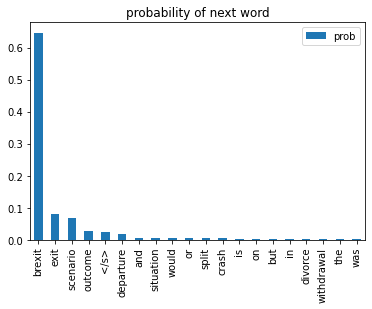

In [437]:
df_prob = pd.DataFrame(list(prob_next_word.most_common(20)),columns=['token','prob'])
df_prob.index = list(df_prob["token"])
df_prob.plot(kind='bar', title='probability of next word')

In [438]:
words, probs = list(prob_next_word),list(prob_next_word.values())

In [439]:
np.random.choice(words, p=probs)

'brexit'

In [440]:
for _ in range(10):
    print(np.random.choice(words, p=probs))

brexit
more
brexit
brexit
may
brexit
brexit
brexit
exit
brexit


In [443]:
def generate_text(sequence):
    """
    """
    
    total_sequence = sequence # to keep track of each prediction we create a variable with the name total_sequence

    next_word = None # we need to define the next word, but assign it a None value

    while next_word != '</s>': # we keep generating text untill we encounter the end of sentence token
        prob_next_word = Counter({w: quadgram[f'{sequence} {w}'] / trigrams[sequence] for w in vocabulary})
        words, probs = list(prob_next_word),list(prob_next_word.values())
        next_word = np.random.choice(words, p=probs)
        total_sequence += ' ' + next_word
        sequence = ' '.join(total_sequence.split()[-3:])
    return total_sequence

In [444]:
#sequence = '<s> theresa may' # select a sequnence as a prompt to start generating texts
#sequence = '<s> boris johnson'
generate_text('<s> theresa may')

'<s> theresa may must accept that leaving with no deal and the judgement is clear that the vote was called they had expected it to have credibility with the british government position still lacks political or moral force to do that would they </s>'